# Synthetic flowline ice stream

In this demo, we'll simulate the evolution of 1D ice stream with both grounded and floating parts.
Ice streams are substantially more complicated than a floating ice shelf.
First, there are more fields.
For floating ice shelves, we only had to consider the velocity, thickness, and fluidity, but for ice streams there's also the surface elevation and bed friction.
Second, the position of the grounded line -- the contour across which the glacier is thin enough to go afloat -- can migrate in time.

The diagnostic equation for an ice stream is similar to that of a floating ice shelf, but for the addition of a term for basal friction:

$$\nabla\cdot hM - C|u|^{1/m - 1}u - \rho gh\nabla s = 0,$$

where $m$ is the *sliding exponent* and $C$ is the *sliding coefficient*.
The glacier state we'll start out with is grounded throughout the entire domain, and during the simulation it will thin out and go afloat part way through.
Accurately predicting grounding line migration is a major problem in glacier flow modeling.

### Geometry and input data

We'll use an elongated fjord-like geometry that extends 50 km from the inflow boundary to the ice front.
The bedrock slopes down from 200 m above sea level at the inflow boundary to -400 m at the terminus; the glacier becomes marine one third of the way into the domain.

In [1]:
import firedrake

Lx = 50e3
nx = 48
mesh = firedrake.IntervalMesh(nx, Lx)

Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.FunctionSpace(mesh, "CG", 2)

/home/firedrake/firedrake/lib/python3.10/site-packages/pytools/__init__.py:2484: UserWarning: unable to find git revision
  warn("unable to find git revision")


The function `firedrake.SpatialCoordinate` always returns a tuple of symbolic variables, even when the geometry is 1D and there's only a single spatial coordinate to return.
That's why the left-hand side of the first assignment below is `x,` to destructure the 1-element tuple, instead of just `x`.

In [2]:
x, = firedrake.SpatialCoordinate(mesh)

b_in, b_out = 200, -400
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

s_in, s_out = 850, 50
s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

h0 = firedrake.interpolate(s0 - b, Q)

As a sanity check, we'll evaluate the driving stress

$$\tau_D = -\rho_Igh\nabla s$$

at the inflow boundary of the ice stream to make sure the value isn't absurd.

In [3]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
)

h_in = s_in - b_in
δs_δx = (s_out - s_in) / Lx
τ_D = -ρ_I * g * h_in * δs_δx
print(f"{1000 * τ_D} kPa")

93.556008 kPa


This stress is on the moderate side for Greenland, high for Antarctica.

Next we have to come up with some rough guess for the initial velocity of the glacier.
Unlike for ice shelves, we can't write down an exact solution for the velocity.
Our best hope is to come up with something vaguely reasonable and tune it by trial and error until we get something that isn't ridiculous.

In [4]:
u_in, u_out = 20, 2400
velocity_x = u_in + (u_out - u_in) * (x / Lx)**2
u0 = firedrake.interpolate(velocity_x, V)

In [5]:
import icepack

T = firedrake.Constant(255.0)
A = icepack.rate_factor(T)

Now to pick a friction coefficient.
We'll use a value of the friction that almost exactly balances the driving stress at the inflow boundary.
Where the glacier goes marine, we'll scale the friction down acoording to the height above flotation.
This is a very rough approximation.
The point is to scale the friction down continuously as the glacier approaches flotation.
If we didn't take care to ramp the friction down and instead just set it to 0 where the ice is floating, we'd get a shock to the system as the bed friction "turns off" across the grounding line.
For a realistic problem, you'd want to take greater account of how the pressure of meltwater at the bed affects friction.

In [6]:
from icepack.constants import weertman_sliding_law as m

expr = (0.95 - 0.05 * x / Lx) * τ_D / u_in**(1 / m)
C = firedrake.interpolate(expr, Q)

p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
p_I = ρ_I * g * h0
ϕ = 1 - p_W / p_I

In the previous examples, we've initialized a model object and then used it directly to compute velocities and thicknesses.
These model objects have sensible defaults for how the physics are parameterized.
For example, we pass in the ice fluidity coefficient $A$, which has units of strain rate $\times$ stress${}^{-3}$.
We could just as easily have used, say, the rheology coefficient $B = A^{-1/n}$, where $n = 3$ is the exponent in Glen's flow law.
You can customize the physics parameterizations by passing in your own Python functions for computing the action functional.
The default in the `IceStream` class is to take in a friction coefficient $C$, but we also want to include the ramping factor, which depends on the ice thickness and surface elevation.
The following function works as a wrapper around the default parameterization, multiplying the friction coefficient by the ramping factor.

In [7]:
import icepack.models.friction

def weertman_friction_with_ramp(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    return icepack.models.friction.bed_friction(
        velocity=u,
        friction=C * ϕ,
    )

Now we can create a model object that uses our new parameterization by passing it to the constructor for the `IceStream` class.
We're calling the model object `model_weertman` because, at the end of this demo, we'll compare with something quite different -- the Schoof model for basal sliding.
The solver object is created in the same way as before.
Customizing the physics changes what problem we're solving, but the algorithms that we use to approximate the solution are identical.

In [8]:
model_weertman = icepack.models.IceStream(
    friction=weertman_friction_with_ramp
)
opts = {
    "dirichlet_ids": [1],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {"snes_type": "newtontr"},
}
solver_weertman = icepack.solvers.FlowSolver(model_weertman, **opts)

u0 = solver_weertman.diagnostic_solve(
    velocity=u0,
    thickness=h0,
    surface=s0,
    fluidity=A,
    friction=C,
)

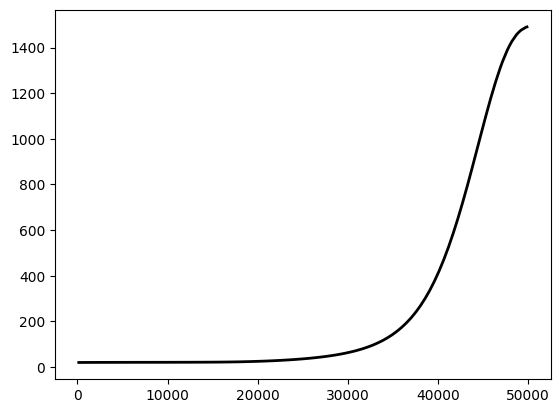

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
firedrake.plot(u0, axes=axes);

Below we show some plots of the basal shear stress and the mass flux.
Note how the basal shear stress gets closer to 0 near the terminus because of how we reduced the friction.

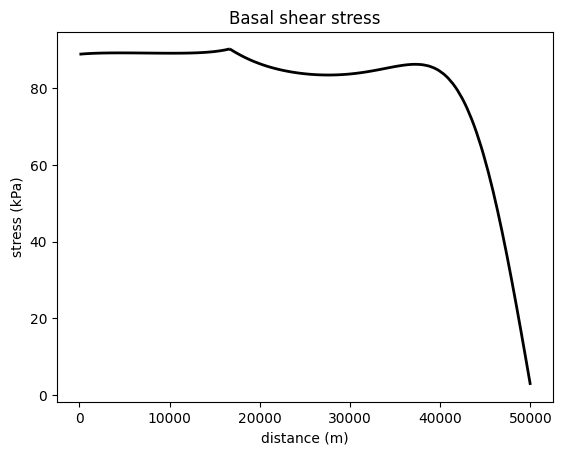

In [10]:
from firedrake import sqrt, inner

τ_b = firedrake.interpolate(1e3 * C * ϕ * u0**(1 / m), V)
fig, axes = plt.subplots()
axes.set_title("Basal shear stress")
axes.set_ylabel("stress (kPa)")
axes.set_xlabel("distance (m)")
firedrake.plot(τ_b, axes=axes);

There's a huge mass balance anomaly near the ice front, an artifact of our choice of initial conditions.
As the simulation progresses, this initial transient should be propagated out of the domain.

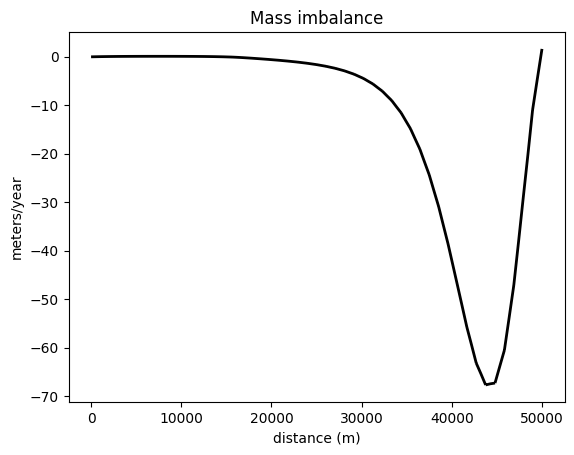

In [11]:
f = firedrake.interpolate(-(h0 * u0).dx(0), Q)
fig, axes = plt.subplots()
axes.set_title("Mass imbalance")
axes.set_xlabel("distance (m)")
axes.set_ylabel("meters/year")
firedrake.plot(f, axes=axes);

### Modeling

Now the good part -- taking our initial glacier state and projecting it forward until it reaches a steady state.
We'll use a timestep of 6 months and the simulation will run for 250 model years.
This is about enough time to propagate out the initial transients and arrive at a state of approximate mass and momentum balance.
I've tuned the accumulation rate so that it roughly balances out the ice flux at the inflow boundary and is within the range of values one might see in southeast Greenland.

In [12]:
import tqdm

num_years = 250
timesteps_per_year = 2

δt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a_in = firedrake.Constant(1.7)
δa = firedrake.Constant(-2.7)
a = firedrake.interpolate(a_in + δa * x / Lx, Q)

h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)

for step in tqdm.trange(num_timesteps):
    h = solver_weertman.prognostic_solve(
        δt,
        thickness=h,
        velocity=u,
        accumulation=a,
        thickness_inflow=h0,
    )
    s = icepack.compute_surface(thickness=h, bed=b)
    
    u = solver_weertman.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
        friction=C,
    )

100%|██████████| 500/500 [00:08<00:00, 62.17it/s] 


Notice that we have one extra step in the middle of the simulation loop.
For ice shelves, all we had to do was (1) update the thickness according to the prognostic equation and then (2) compute the new ice velocity corresponding to this thickness.
Since ice shelves are floating, we can calculate the surface elevation as a function of the ice thickness knowing the densities of ice and ocean water, and this is baked into the formulation of the problem.
Ice streams, on the other hand, can be grounded or floating.
After we update the ice thickness, we need to explicitly calculate a new surface elevation in a way that accounts for whether the ice is floating or grounded, and that's what the function `icepack.compute_surface` does.
Let's see what the results look like.

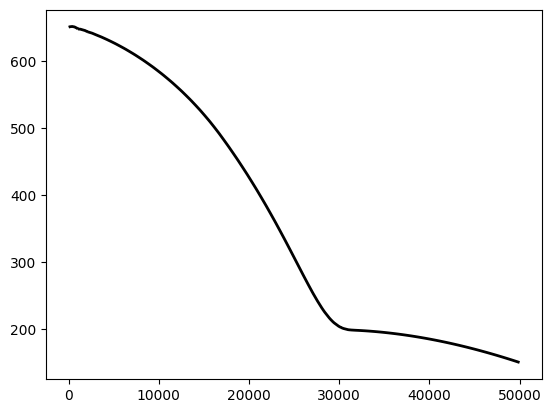

In [13]:
fig, axes = plt.subplots()
firedrake.plot(h, axes=axes);

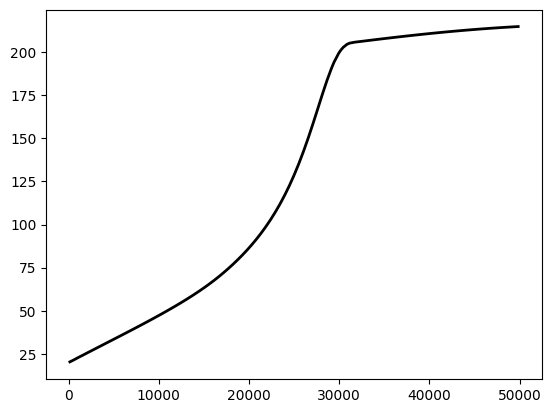

In [14]:
fig, axes = plt.subplots()
firedrake.plot(u, axes=axes);

We can see by plotting the mass balance that, despite some wiggles, the system is much closer to equilibrium than it was at the start.
Before, the mass imbalance was on the order of 70 meters / year, whereas now the amplitude is about 12.5 cm / year.

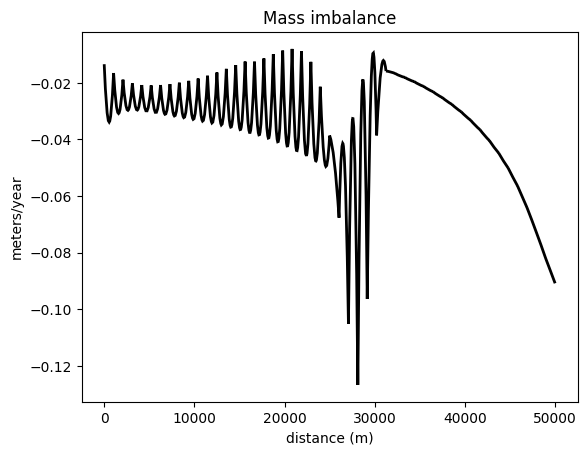

In [15]:
f = firedrake.interpolate(a - (h * u).dx(0), Q)
fig, axes = plt.subplots()
axes.set_title("Mass imbalance")
axes.set_xlabel("distance (m)")
axes.set_ylabel("meters/year")
firedrake.plot(f, axes=axes);

Finally, we can plot what the surface, bed, and ice base elevation look like in the $x, z$-plane.

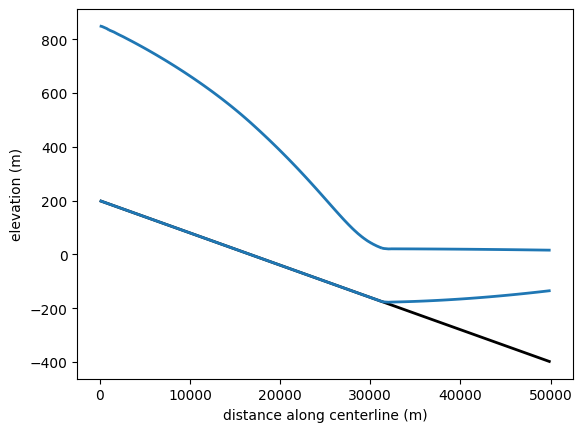

In [16]:
import numpy as np
import matplotlib.pyplot as plt

z_b = firedrake.interpolate(s - h, Q)

fig, axes = plt.subplots()
firedrake.plot(b, edgecolor="black", axes=axes)
firedrake.plot(s, edgecolor="tab:blue", axes=axes)
firedrake.plot(z_b, edgecolor="tab:blue", axes=axes)
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)");

Notice how the glacier exhibits the typical drop in thickness gradient as it crosses the grounding line.

### Recap

The demonstration above shows how to simulate the evolution of a grounded ice stream; while there are more fields to keep track of than for a floating ice shelf, the basic principles are still the same.

Coming up with physically plausible synthetic test cases is difficult.
The variables that we can control are the bed geometry, the accumulation rate, and the ice flux at inflow.
To a certain extent, we can pick the friction coefficient, but this can change in ways that are difficult to predict as parts of the glacier begin to float.
Our initial state was far out of mass balance and we let it evolve towards equilibrium, but we don't know ahead of time what surface slope or stretching rate the glacier will settle on in the end.

The eventual steady state could be physically implausible for reasons that weren't obvious from the start.
For example, if the ice strain rate increases beyond what we expect after a few years of model time, the mass flux at the inflow boundary could be much larger than what the influx and accumulation rate can supply, leading to an unphysically sharp drop in the surface.
Preparing this demonstration required lots of trial and error to get the parameters just right, and that's to be expected.

The bed elevation we used sloped down towards the ocean; had we instead used a bed elevation that sloped down going inland, the configuration would be unstable due to marine ice sheet instability.
An interesting variation on this demo could be to use a bed geometry with several stable pinning points, interspersed with unstable retrograde slopes.

### Changing the model physics

In the first part of this demo, we used the usual Weertman sliding law, where the basal shear stress is proportional to some power of the ice sliding speed.
Weertman sliding assumes that the glacier slides by regelation.
Where the glacier flows over deformable sediments, the sliding relation could instead approach plasticity -- the stress depends only on the direction and not the magnitude of the velocity.
Other sliding laws have been proposed that exhibit this feature, for example the law proposed in Schoof (2005), The effect of cavitation on glacier sliding.

In icepack, all of the diagnostic model physics is prescribed through an action principle.
Rather than specify how the shear stress depends on the ice velocity, we specify the frictional energy dissipation.
The stress is then the functional derivative of the dissipation with respect to velocity.
For the Weertman sliding law

$$\tau_b = -C|u|^{\frac{1}{m} - 1}u,$$

the energy dissipation is

$$E(u) = \int \frac{m}{m + 1}C|u|^{\frac{1}{m} + 1}dx.$$

In the first part of the demo, we showed how to slightly modify the physics by adding a thickness- and elevation-dependent factor to reduce the friction when the glacier bed is below sea level.
In the following, we'll show how to use a completely different model of glacier sliding.

### The Schoof sliding law

To modify the Weertman sliding law for high ice speeds, we need for the energy dissipation density to be asymptotically like $|u|^1$ for large $u$, but like $|u|^{1/m + 1}$ for small $u$.
"Small" and "large" will be defined relative to some reference or threshold speed $U_0$.
While it doesn't exactly reproduce the Schoof sliding law itself, the following functional gives the right asymptotic behavior:

$$E(u) = \int \tau_0\left(\left(U_0^{\frac{1}{m} + 1} + |u|^{\frac{1}{m} + 1}\right)^{\frac{m}{m + 1}} - U_0\right) dx$$

The extra factor of $-U_0$ is there to make it so that $E(0) = 0$, i.e. there is no dissipation when there is no flow.
The right value of $U_0$ isn't very well constrained.
For this demonstration, we'll use a value of 50 m/year, since this falls roughly in the middle of the grounded region for the final velocity.
We'll then choose the value of the factor $\tau_0$, which has units of stress, so that the stress is the same as the value at the end of the simulation we've just run using Weertman sliding.

In [17]:
U_0 = firedrake.Constant(50)
U = sqrt(inner(u, u))
τ_0 = firedrake.interpolate(
    C * (U_0**(1 / m + 1) + U**(1 / m + 1))**(1 / (m + 1)), Q
)

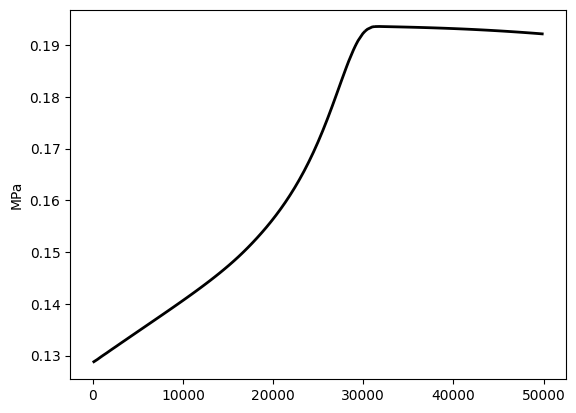

In [18]:
fig, axes = plt.subplots()
axes.set_ylabel("MPa")
firedrake.plot(τ_0, axes=axes);

The following function returns the kernel of the action functional associated to this sliding law, given the ice velocity, elevation, and the yield stress.
Note that we only need to provide the inside of the integral -- the model object applies the measures (`dx`, `ds`, etc.) for you.

In [19]:
def schoof_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    τ_0 = kwargs["yield_stress"]

    ϕ = 1 - ρ_W / ρ_I * firedrake.max_value(0, h - s) / h
    U = sqrt(inner(u, u))
    return τ_0 * ϕ * (
        (U_0**(1 / m + 1) + U**(1 / m + 1))**(m / (m + 1)) - U_0
    )

Before we go on, let's take a look at what the basal shear stress actually looks like.
Recall that the quantity we defined above is the rate of free energy dissipation due to frictional stress.
To get the actual basal shear, we'll take the derivative of this quantity with respect to the velocity $u$.
The analytical formula for the stress is

$$\tau = -\frac{\tau_0|u|^{\frac{1}{m} - 1}u}{\left(U_0^{\frac{1}{m} + 1} + |u|^{\frac{1}{m} + 1}\right)^{\frac{1}{m + 1}}}.$$

Observe how the magnitude of the basal shear is asymptotic to $|u|^{1/m}$ when $|u| \ll U_0$, but to $\tau_0$ when $|u| \gg U_0$.

To calculate the basal shear, we could painstakingly write out this whole formula in Python.
Or we could take advantage of the symbolic differentiation features of the form language by first creating the free energy dissipation `F` and then calling `firedrake.diff` on it.

In [20]:
F = schoof_friction(
    velocity=u,
    thickness=h,
    surface=s,
    yield_stress=τ_0,
)
τ = firedrake.interpolate(-firedrake.diff(F, u), V)

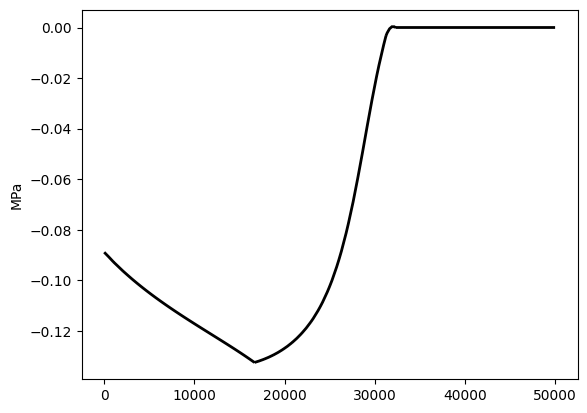

In [21]:
fig, axes = plt.subplots()
axes.set_ylabel("MPa")
firedrake.plot(τ, axes=axes);

This matches up with what we expect -- higher stress at the grounded part of the ice stream, which then decreases to 0 towards the grounding line.

Now we can create a new `IceStream` object that will use this function to calculate the action rather than the usual Weertman sliding law:

In [22]:
model_schoof = icepack.models.IceStream(friction=schoof_friction)

The Schoof friction functional that we defined above takes in more parameters than the usual Weertman law, but thanks to keyword arguments in Python, everything gets passed to the right place despite this change.
Let's do a diagnostic solve with this new model and see how different it is from the velocity obtained with the Weertman sliding law.

In [23]:
solver_schoof = icepack.solvers.FlowSolver(model_schoof, **opts)
u_schoof = solver_schoof.diagnostic_solve(
    velocity=u,
    thickness=h,
    surface=s,
    fluidity=A,
    yield_stress=τ_0,
)

ConvergenceError: Nonlinear solve failed to converge after 2 nonlinear iterations.
Reason:
   DIVERGED_TR_DELTA

NameError: name 'u_schoof' is not defined

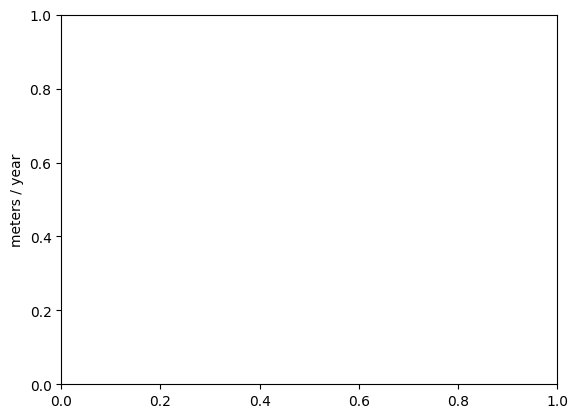

In [24]:
fig, axes = plt.subplots()
axes.set_ylabel("meters / year")
firedrake.plot(u_schoof, axes=axes);

In [25]:
icepack.norm(u - u_schoof)

NameError: name 'u_schoof' is not defined

Just as we expect -- the resulting velocities are practically the same.
We picked the parameters in the Schoof sliding law to give the same basal shear stress as with the Weertman law, so we should get the same velocity.

### Response to perturbations

The steady state we've found is roughly an equilibrium for both the Weertman and Schoof sliding laws.
To conclude this demo, we'll increase the melt rate under the floating ice tongue and see how the system responds.
To perturb the system out of its current equilibrium state, we'll add an extra 1 m/year of melting in the right-hand side of the domain.
If we wanted to be more physically realistic about things, we might set the melt rate to be a function of depth below sea level, or even use a plume model.

In [26]:
from firedrake import conditional
a = firedrake.interpolate(
    a_in + δa * x / Lx - conditional(x/Lx > 0.5, 1.0, 0.0), Q
)

We'll wrap up the same loop as we had before in a function that takes in the model (Weertman or Schoof) as an argument.
This saves a bit of repetition and makes it easier to parallelize later.

In [27]:
num_years = 100
timesteps_per_year = 2

δt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

def run_simulation(solver, h, s, u, **kwargs):
    for step in tqdm.trange(num_timesteps):
        h = solver.prognostic_solve(
            δt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h0,
        )
        s = icepack.compute_surface(thickness=h, bed=b)
        
        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            **kwargs,
        )

    return h, s, u

h_weertman, s_weertman, u_weertman = run_simulation(
    solver_weertman, h, s, u, fluidity=A, friction=C
)

h_schoof, s_schoof, u_schoof = run_simulation(
    solver_schoof, h, s, u_schoof, fluidity=A, yield_stress=τ_0
)

100%|██████████| 200/200 [00:01<00:00, 109.93it/s]


NameError: name 'u_schoof' is not defined

Finally, we'll plot a transect of the difference in thickness between the Weertman and Schoof laws.
The glacier loses more mass over the grounded region and less under the ice shelf with the Schoof law than with the Weertman law.
When the sliding relation becomes more plastic, the bed can take up less of the increased driving stress resulting from steeper surface slopes, so that changes under the ice shelf are evident further upstream.

In [28]:
δh = firedrake.interpolate(h_weertman - h_schoof, Q)

fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("thickness difference (m)")
firedrake.plot(δh, axes=axes);

NameError: name 'h_schoof' is not defined

### Conclusion

The Schoof sliding law is, arguably, more physically realistic than the Weertman sliding law for fast-flowing outlet glaciers or ice streams.
While icepack defaults to using the Weertman sliding law, replacing it with the Schoof law consists of only a few lines of code.
First, we have to write a function that calculates the energy dissipation from Schoof-type sliding.
We then have to pass this function to the constructor of the `IceStream` model object we use to calculate the ice velocity.
By passing in all the input fields to the `diagnostic_solve` method as keyword arguments, we don't have to rewrite or override any methods of `IceStream`, despite the fact that there are more input fields to the Schoof sliding law than there are for the Weertman law.

In switching to the Schoof sliding law, we showed how the physics could be modified to take in a possibly arbitrary number of different fields beyond the default physics parameterization.
These additional fields could themselves be computed by solving other PDEs.
For example, we could define the basal shear stress to be a function of the effective water pressure, which would then solve for using some model of subglacial hydrology.